# **COLORAZIONE AUTOMATICA DI IMMAGINI: GESTIONE del DATASET**
---

# Introduzione

La **colorazione automatica** 🖼️ è il processo mediante il quale un'immagine in bianco e nero, o più precisamente in **scala di grigi**, viene trasformata in un'immagine a **colori**.
Sebbene possa sembrare un compito semplice, richiede in realtà una profonda comprensione del contenuto visivo: non si tratta infatti di aggiungere colori in modo arbitrario, ma di assegnare tonalità realistiche e coerenti con la scena rappresentata.

La **colorazione manuale** 🎨 delle immagini è un’operazione complessa che implica un notevole **impegno umano**, **tempi lunghi** e una **spiccata sensibilità artistica**. Proprio per questo motivo, lo sviluppo di tecniche automatizzate capaci di imitare, almeno in parte, il processo decisionale umano nella scelta dei colori rappresenta una sfida significativa nel campo dell'elaborazione delle immagini.

Questo progetto si propone di **esplorare** e **confrontare** diverse t**ecniche di apprendimento profondo** applicate alla colorazione automatica, con l'obiettivo di **ottenere risultati** visivamente **credibili** e **coerenti** per l’**occhio umano**.
<br></br>
***È possibile “ridare vita” a vecchie fotografie in bianco e nero grazie all'apprendimento automatico profondo?***
<br></br>
A partire da questa domanda prende avvio l’indagine sull’impiego del deep learning 🧠 in questo specifico compito.
In questo notebook verrà introdotto, analizzato e preparato il dataset scelto, in vista della sua successiva applicazione ai modelli di apprendimento automatico profondo.

# Inclusione delle librerie utili

Importiamo alcune librerie fondamentali che ci aiuteranno a gestire i dati, lavorare con *Google Drive* e visualizzare le immagini.

Utilizziamo **drive** e **files** per caricare il dataset direttamente nel nostro spazio di lavoro tramite drag & drop, mentre **numpy** ci permette di salvare i **dati pre-processati** in comodi file *.npy*.

Per gestire archivi compressi in formato .zip (come sarà il dataset una volta scaricato da kaggle) ci affidiamo alla libreria **zipfile**, mentre **os** ci consente di creare e organizzare directory in modo efficiente.
Infine, **matplotlib** sarà utile per mostrare in modo chiaro e intuitivo le immagini che compongono il dataset [***Landscape color and grayscale images***](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization/code)

In [ ]:
from google.colab import drive, files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import zipfile
from tqdm import tqdm
import numpy as np

# Download Dataset

In [ ]:
# Montaggio di GOOGLE DRIVE nel workspace
try:
    drive.mount('/content/drive')
    print("Google Drive montato con successo.")
except Exception as e:
    print(f"Errore durante il montaggio di Google Drive: {e}")
    exit()

Mounted at /content/drive
Google Drive montato con successo.


In [ ]:
uploaded = files.upload('/content/drive/MyDrive/DL_project')

Saving archive.zip to /content/drive/MyDrive/DL_project/archive (1).zip


In [ ]:
# Definiamo il path della directory in cui abbiamo salvato il dataset originale
original_dataset_path = '/content/drive/MyDrive/DL_project/landscape Images'

# Specificare il nome corretto del file zip: scaricando il dataset da kaggle il nome corretto è 'archive.zip'
zip_path = "/content/drive/MyDrive/DL_project/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    file_list = zip_ref.namelist()
    for file in tqdm(file_list, desc="Estrazione file"):
        zip_ref.extract(file, '/content/drive/MyDrive/DL_project')

print("File estratti:")
print(os.listdir(original_dataset_path))

Estrazione file: 100%|██████████| 14258/14258 [03:29<00:00, 67.95it/s]

File estratti:
['color', 'gray']


Definiamo i percorsi principali che utilizzeremo per il caricamento e la gestione del dataset. `original_dataset_path` indica la directory contenente le immagini originali (suddivise in sotto cartelle), mentre `processed_dataset_path` sarà la cartella in cui salveremo le immagini preprocessate. Vengono inoltre specificati due sotto-percorsi: `color_path`, che contiene le *immagini a colori* e `gray_path`, che contiene le corrispondenti versioni in *scala di grigio*.

In [ ]:
# Definiamo i due percorsi da cui andremo a prendere rispettivamente le immagini a colori e le immagini in bianco e nero
color_path = '/content/drive/MyDrive/DL_project/landscape Images/color'
gray_path= '/content/drive/MyDrive/DL_project/landscape Images/gray'

# Definiamo i path delle directory in cui vogliamo salvare il dataset processato
processed_dataset_path = '/content/drive/MyDrive/DL_project/processed_dataset'
processed_rgb_dataset_path = os.path.join(processed_dataset_path, 'RGB')
processed_lab_dataset_path = os.path.join(processed_dataset_path, 'LAB')

# Definiamo i path delle directory dove salviamo il dataset processato per la GAN
processed_rgb_dataset_path_GAN = os.path.join(processed_dataset_path, 'GAN')

In [ ]:
# Richiamiamo la funzione listdir() di os e creiamo le liste contenenti i nomi dei file delle immagini a colori e in scala di grigi recuperate dal dataset
color_files = os.listdir(color_path)
gray_files = os.listdir(gray_path)

# Riordiniamo le liste in ordine alfanumerico
color_files = sorted(color_files, key=lambda x: int(x.split('.')[0]))
gray_files = sorted(gray_files, key=lambda x: int(x.split('.')[0]))

# Per assicurarci che l’importazione sia avvenuta correttamente, stampiamo il numero totale di immagini, sia a colori che in scala di grigio (dal dataset sappiamo che sono 7129 immagini per ciacun gruppo)
print(f'Le immagini a colori sono {len(color_files)}')
print(f'Le immagini in scala di grigi sono {len(gray_files)}')

Le immagini a colori sono 7129
Le immagini in scala di grigi sono 7129


## Codifica RGB

La ***codifica RGB*** 🎨 è uno dei metodi più comuni per rappresentare il colore nelle immagini digitali. Questo metodo si basa su *tre canali* principali: **Red** (rosso), **Green** (verde) e **Blue** (blu), ognuno dei quali può assumere un valore compreso tra 0 e 255. Combinando questi tre valori, è possibile ottenere un'ampia gamma di colori — nello specifico, **256³** combinazioni, ovvero circa **16 milioni** di **tonalità differenti**.

Al contrario, un'immagine in ***scala di grigio*** ◻️⬜️◾️ utilizza *un solo canale* ed è codificata su **8 bit**, rappresentando esclusivamente il **livello di intensità luminosa**. I valori vanno da **0 (nero assoluto)** a **255 (bianco assoluto)**, passando per tutte le gradazioni intermedie di grigio. In questo tipo di rappresentazione non vengono memorizzate informazioni cromatiche, ma solo la **quantità di luce** presente in ciascun pixel.

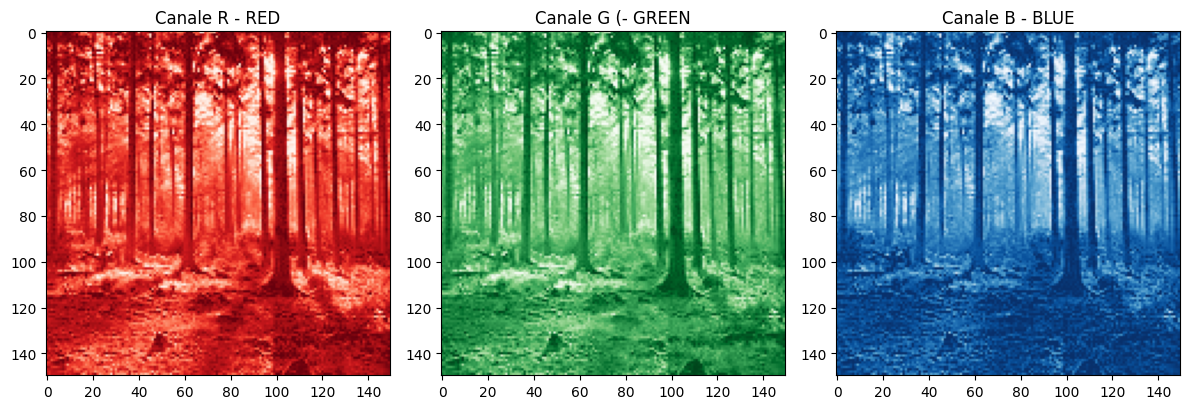

In [ ]:
# Leggiamo un' immagine di esempio per approfondire graficamente la codifica RGB
img_bgr = cv2.imread("/content/drive/MyDrive/DL_project/landscape Images/color/80.jpg", cv2.IMREAD_COLOR)

# Convertiamo da BGR a RGB (ricordiamo che cv2 legge in BGR)
rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Visualizza i canali RGB
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].set_title("Canale R - RED")
ax[0].imshow(255-rgb[:, :, 0], cmap='Reds')
ax[1].set_title("Canale G (- GREEN")
ax[1].imshow(255-rgb[:, :, 1], cmap='Greens')
ax[2].set_title("Canale B - BLUE")
ax[2].imshow(255-rgb[:, :, 2], cmap='Blues')

# Nota: Quando plottiamo i canali, li invertiamo sottraendoli da 255 per motivi puramente grafici.
# Questo accorgimento migliora il contrasto visivo, rendendo più evidenti le variazioni di intensità e facilitando l’interpretazione dell'immagine.

plt.tight_layout()
plt.show()


In [ ]:
# Definiamo la dimensione delle immagini da utilizzare nella resize
IMG_SIZE = 128
IMG_SIZE_GAN = 256

# Creiamo due liste dove salvaremo le immagini dopo averle pre processate
# In un modello autoencoder, gray_img funge da input (X) e color_img da target (Y), ovvero l'immagine che il modello deve imparare a ricostruire.
color_img = [] #shape di ciascuna immagine della lista = (IMG_SIZE, IMG_SIZE, 3)
gray_img = [] #shape di ciascuna immagine della lista = (IMG_SIZE, IMG_SIZE, 1)

color_img_gan = []
gray_img_gan = []

La funzione definita sotto, consente di leggere le immagini utilizzando la funzione `cv2.imread()`, che accetta come secondo parametro una flag per specificare la modalità di lettura. Nel nostro caso, il task prevede l'uso di immagini a colori (3 canali) come target e immagini in scala di grigio (1 canale) come input.

L'attuale scelta progettuale prevede l'utilizzo della **flag 1** per la lettura delle **immagini a colori**, che restituisce l'immagine in **formato BGR**, e della **flag 0** per le **immagini in scala di grigio**.

*Tuttavia, per rendere il **modello** più **flessibile** e ampliare le possibilità di applicazione, si potrebbe considerare l'idea di leggere tutte le immagini con la flag 1, forzando quindi una lettura in 3 canali anche per le immagini non pienamente a colori.*

Questa strategia permetterebbe, ad esempio, di utilizzare come input anche fotografie con leggere sfumature cromatiche (come quelle in seppia) trattandole comunque come immagini da colorare. In questo modo il modello potrebbe potenzialmente "riportare in vita" un insieme più ampio e variegato di immagini, andando oltre la semplice scala di grigi.


Questa possibile estensione progettuale rappresenta un **interessante spunto applicativo**, in grado di ampliare le potenzialità del modello, pur comportando un inevitabile **aumento del carico computazionale**.

In [ ]:
# Funzione per leggere le immagini con differente codifica (RGB e GRAY_SCALE)
def read_img_rgb_encoding(files, path, flag, model):
    readed_img = []
    for idx, filename in enumerate(tqdm(files, desc="Reading images")):

        # Recuperiamo il path completo che punta all'immagine corrente da leggere
        full_path = os.path.join(path, filename)

        try:

            # flag 0 -> cv2.IMREAD_ GRAYSCALE -> shape=(IMG_SIZE, IMG_SIZE, 1)
            # flag 1 -> cv2.IMREAD_ IMREAD_COLOR -> shape=(IMG_SIZE, IMG_SIZE, 3)
            img = cv2.imread(full_path, flag) # di default le immaigni vengono caricate come array numpy di tipo uint8, range valori [0,255]

            # Gestiamo l'errore in cui cv2.imread() fallisce. Stampiamo il nome dell'immagine che ha causato l'errore
            if img is None:
                raise ValueError(f"Image '{filename}' could not be read. It may be corrupted or the path is incorrect.")

            # Se flag == 1 cv2 restituisce 3 canali BGR: occorre convertirla in RGB
            if flag == 1: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if model == 'AE':
              # Facciamo il resize dell'immagine in base alla dimensione che abbiamo scelto e applichiamo la normalizzazione dividendo per 255
              img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
              img = img.astype('float32') / 255.0
            else:
              # Effettuiamo la resize dell'immagine, trasformiamo la shape da 128x128 a 256x256
              img = cv2.resize(img, (IMG_SIZE_GAN, IMG_SIZE_GAN))
              # Normalizziamo trasformando il range di valori in [-1,1] perché per la gan è preferibile (utilizziamo la tanh)
              img = (img.astype('float32') / 127.5) -1  # utilizziamo 127.5 perché è esattamente la metà di 255

            readed_img.append(img)

        except Exception as e:
            print(f"[Errore]: {str(e)}")

    return np.array(readed_img)


In [ ]:
# Richiamiamo la funzione per entrambi i path e assegniamo le immagini alle rispettive liste
color_img = read_img_rgb_encoding(color_files, color_path, 1, 'AE')
gray_img = read_img_rgb_encoding(gray_files, gray_path, 0, 'AE')

Reading images: 100%|██████████| 7129/7129 [58:54<00:00,  2.02it/s]


In [ ]:
# Aggiunge il canale (1) per immagini in scala di grigio
gray_img = np.expand_dims(gray_img, axis=-1)

In [ ]:
os.makedirs(processed_rgb_dataset_path, exist_ok=True)

In [ ]:
# Salvataggio delle immagini pre-processate in formato .npy
# Questo tipo di salvataggio rende i dati facilmente portabili e accessibili, consentendoci un facile caricamento nelle fasi successive
np.save(processed_rgb_dataset_path + '/color_img.npy', color_img)
np.save(processed_rgb_dataset_path + '/gray_img.npy', gray_img)

In [ ]:
del color_img, gray_img

In [ ]:
color_img_gan = read_img_rgb_encoding(color_files, color_path, 1, 'GAN')
gray_img_gan = read_img_rgb_encoding(gray_files, gray_path, 0, 'GAN')

Reading images: 100%|██████████| 7129/7129 [37:27<00:00,  3.17it/s]


Ora che le immagini a colori e in scala di grigio sono state pre-processate, è indispensabile salvarle per poterle riutilizzare in nuovi notebook senza dover eseguire nuovamente il pre-processing.

In [ ]:
gray_img_gan = np.expand_dims(gray_img_gan, axis=-1)

In [ ]:
print(gray_img_gan.shape)
print(color_img_gan.shape)

(7129, 256, 256, 1)
(7129, 256, 256, 3)


In [ ]:
os.makedirs(processed_rgb_dataset_path_GAN, exist_ok=True)

In [ ]:
# Salvataggio delle immagini con differente shape che saranno utilizzate dalla cGan
np.save(processed_rgb_dataset_path_GAN + '/color_img_GAN.npy', color_img_gan)
np.save(processed_rgb_dataset_path_GAN + '/gray_img_GAN.npy', gray_img_gan)

## Codifica LAB

Un altro spazio colore molto utilizzato, soprattutto in ambito di elaborazione delle immagini, è il **LAB** (noto anche come **CIELAB**).

Come lo spazio RGB, anche LAB rappresenta i colori attraverso **tre canali**, ma si distingue per il tipo di informazione codificata in ciascuno di essi:

- **Canale L (Lightness)**: *rappresenta la **luminosità** dell’immagine, con valori che vanno da 0 (nero) a 100 (bianco). Si avvicina concettualmente ad un’immagine in scala di grigi, anche se le immagini grayscale comuni hanno in genere 256 valori per pixel (da 0 a 255) e non solo 100.*

- **Canale A**: *descrive lo spettro colore **verde-rosso**, con valori che vanno da -128 (verde) a +127 (rosso).*

- **Canale B:** *rappresenta lo spettro **blu-giallo**, con valori che vanno da -128 (blu) a +127 (giallo).*


In sintesi, lo **spazio colore LAB** separa la **componente luminosa** dell’immagine (canale L) dalla **componente cromatica** (canali a e b), che viene codificata su due assi opposti: verde/rosso e blu/giallo.
Questa separazione rende lo spazio LAB particolarmente utile in applicazioni di colorizzazione e correzione del colore, poiché permette di manipolare luce e colore in maniera indipendente.

*Di seguito vengono visualizzati separatamente i tre canali dello spazio colore LAB, a partire da un'immagine di esempio prelevata dal dataset. Questo consente di osservare in modo diretto come ciascun canale contribuisce alla rappresentazione complessiva del colore.*

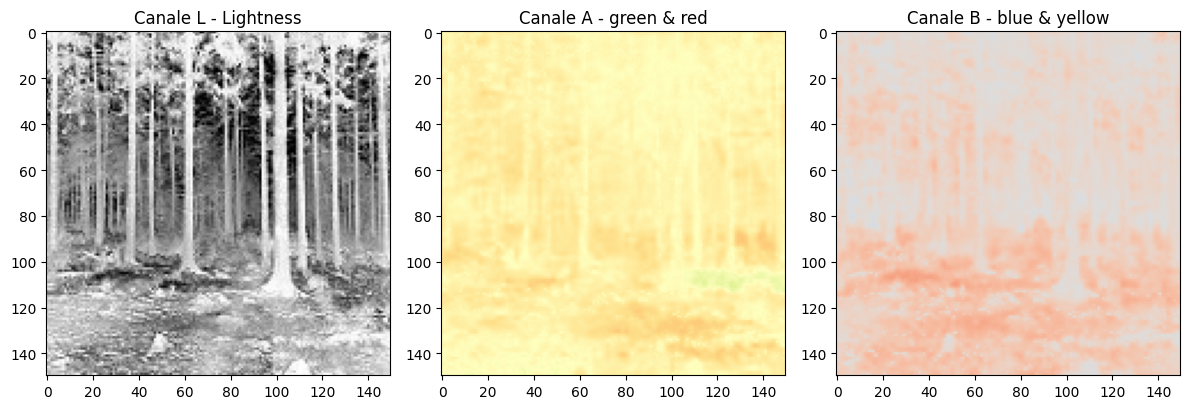

In [ ]:
# Leggiamo un'immagine di esempio per approfondire graficamente la codifica LAB
img_bgr = cv2.imread("/content/drive/MyDrive/DL_project/landscape Images/color/80.jpg", cv2.IMREAD_COLOR)

# Convertiamo l'immagine da BGR a LAB (ricordiamo che cv2 legge in BGR)
lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

# Splittiamo i canali nelle variabili L, A e B
L = 255 - lab[:, :, 0]
A = lab[:, :, 1].astype(np.int16) - 128
B = lab[:, :, 2].astype(np.int16) - 128

# Visualizziamo i canali LAB
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].set_title("Canale L - Lightness")
ax[0].imshow(L, cmap='gray')  # Luminosità in scala di grigi
ax[1].set_title("Canale A - green & red")
ax[1].imshow(A, cmap='RdYlGn', vmin=-128, vmax=127)  # Colori tra verde e rosso
ax[2].set_title("Canale B - blue & yellow")
ax[2].imshow(B, cmap='coolwarm', vmin=-128, vmax=127)  # Colori tra blu e giallo

plt.tight_layout()
plt.show()

*La rappresentazione dei canali A e B potrebbe inizialmente sembrare errata, ma in realtà riflette correttamente le informazioni cromatiche dell'immagine. I colori visualizzati nei due canali dipendono dalle tonalità effettivamente presenti nell'immagine: se queste non sono spinte verso gli estremi dello spettro LAB, ciò che apparirà nei canali A e B saranno sfumature più neutre.*

Nel canale A, ad esempio, predominano tonalità giallo-verdi quando i valori sono vicini allo zero, ossia al punto neutro tra verde e rosso.

Analogamente, nel canale B, le sfumature grigiastre indicano un bilanciamento tra blu e giallo.

In [ ]:
# Definiamo la dimensione delle immagini da utilizzare nella resize
IMG_SIZE = 128

# Creiamo due liste per memorizzare separatamente il canale L (input del modello) e i canali AB (target da prevedere).
L = [] #shape di ciascuna elemento della lista = (IMG_SIZE, IMG_SIZE, 1)
AB = [] #shape di ciascuna elemento della lista = (IMG_SIZE, IMG_SIZE, 2)

Per leggere le immagini con codfica lab le leggiamo con cv2 poi prima effettuiamo la resize con img size, poi convertiamo in lab e ci assicuriamo che i valori siano float32. Non possiamo fare la resize dopo la conversione con lab perché altrimenti i valori risulterebbero 'schiacciati' e le normalizzazioni sarebbero errate portando ad avere immagini troppo scure.

In [ ]:
def read_img_lab_encoding(files, path):
    L = []
    AB = []

    for idx, filename in enumerate(tqdm(files, desc="Reading LAB images")):

      # Recuperiamo il path completo che punta all'immagine corrente da leggere
      full_path = os.path.join(path, filename)

      try:

          # Leggiamo le immagini a colori, settando il flag a 1 (cv2.IMREAD_COLOR)
          img = cv2.imread(full_path, 1)

          if img is None:
              raise ValueError(f"Image '{filename}' could not be read. It may be corrupted or the path is incorrect.")

          # Resize
          img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

          # Normalizzazione
          img = img.astype('float32') / 255

          # cv2 restituisce 3 canali BGR: occorre convertirla in LAB
          img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

          # Salviamo nella lista L il canale Lightness (luminosità)
          # e nella lista AB i canali a (green-red) e b (blue-yellow)
          L.append(img[:, :, 0] / 100)
          AB.append(img[:, :, 1:] / 128)

      except Exception as e:
          print(f"[Errore] Immagine '{filename}': {str(e)}")

    L = np.array(L).reshape((-1, IMG_SIZE, IMG_SIZE, 1))
    AB = np.array(AB)

    return L, AB


In [ ]:
# Richiamiamo la funzione e assegniamo i risultati alle liste L e AB
L, AB = read_img_lab_encoding(color_files, color_path)

Reading LAB images: 100%|██████████| 7129/7129 [00:44<00:00, 159.62it/s]


Ora che le immagini sono state pre-processate separandole nei canali L, A e B, è fondamentale salvarle, così da poterle riutilizzare facilmente in altri notebook senza dover ripetere l'intero processo.

In [ ]:
os.makedirs(processed_lab_dataset_path, exist_ok=True)

In [ ]:
# Salvataggio dei canali pre-processati in formato .npy
# Questo tipo di salvataggio rende i dati facilmente portabili e accessibili, consentendoci un facile caricamento nelle fasi successive
np.save(processed_lab_dataset_path + '/L_channels.npy', L)
np.save(processed_lab_dataset_path + '/AB_channels.npy', AB)

# Analisi esplorativa del dataset
Mostriamo le prime 10 coppie di immagini per capire con cosa andrà a lavorare il nostro autoencoder

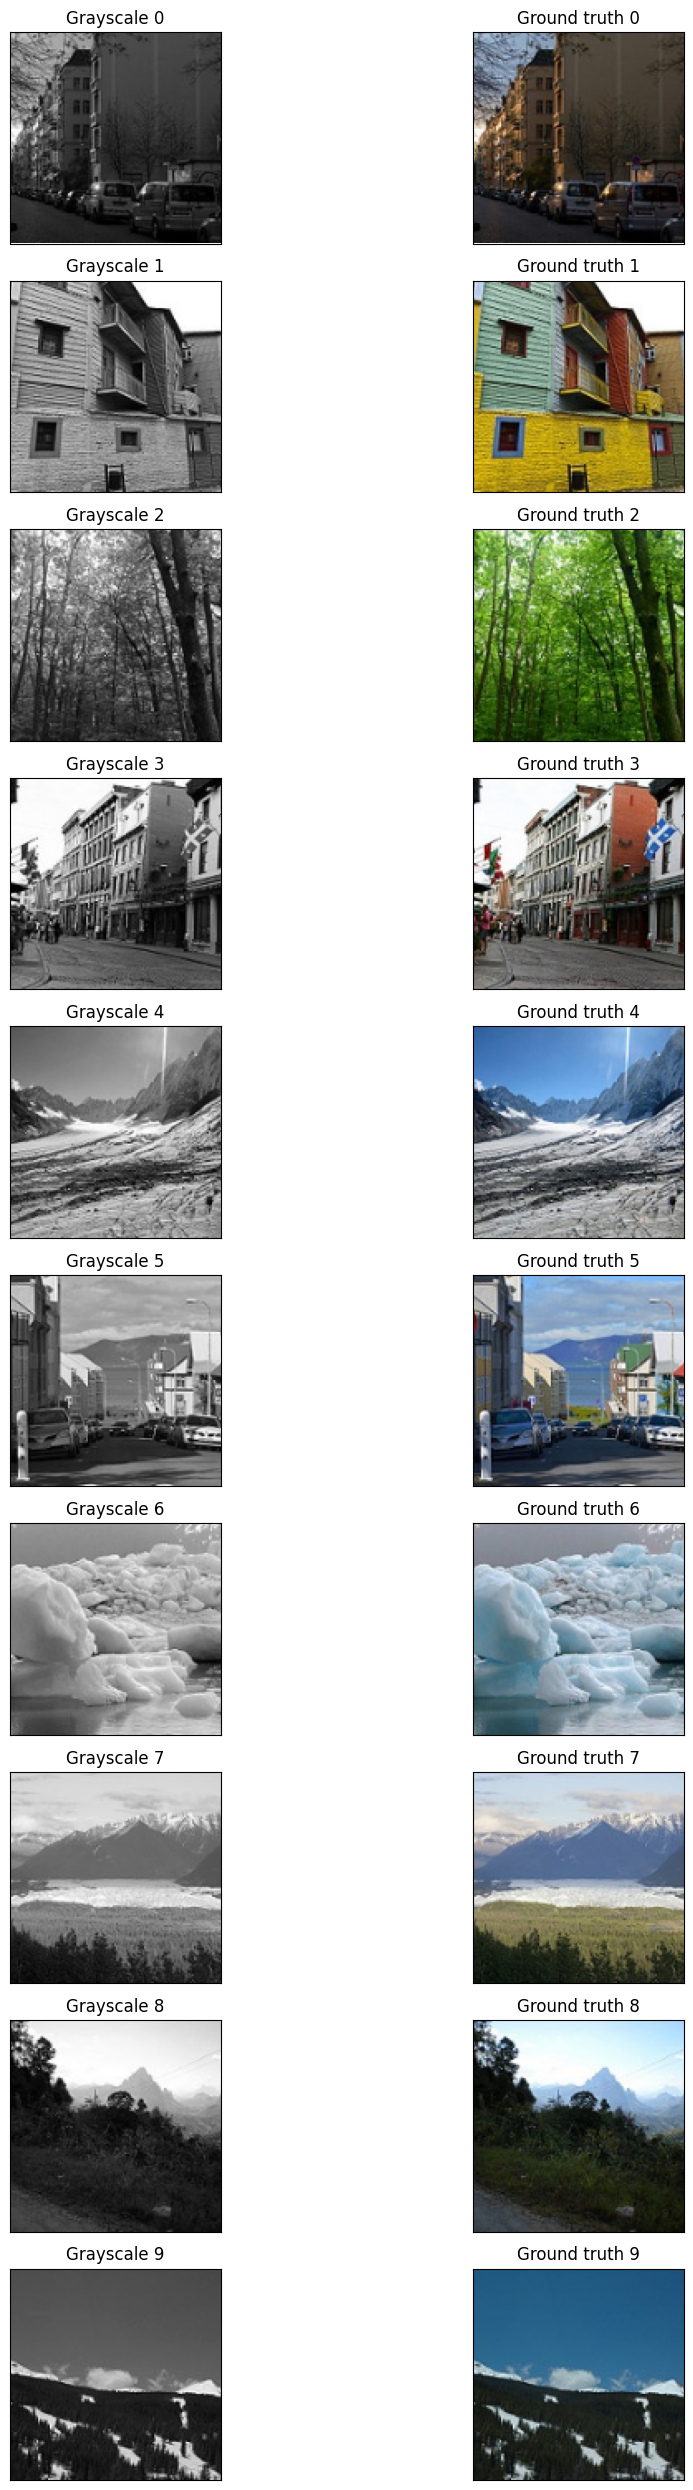

In [ ]:
n = 10
plt.figure(figsize=(12, 25))

for i in range(n):
  # immagini in scala di grigio
  ax = plt.subplot(10, 2, 2*i + 1)
  plt.imshow(tf.squeeze(gray_img[i]), cmap='gray')
  plt.title(f"Grayscale {i}")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # immagini a colori
  ax = plt.subplot(10, 2, 2*i + 2)
  plt.imshow(color_img[i])
  plt.title(f"Ground truth {i}")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

Caricamento dei file

https://stackoverflow.com/questions/71268961/unable-to-upload-local-files-to-google-colab-file-upload-does-not-respond/78274523

Pre Processing e Normalizzazione immagini - LAB03

https://colab.research.google.com/drive/1oHeKUqnqJ1ni-xoy4GFGYnGqcMnDu3tV


Salvataggio dati preprocessati:

https://stackoverflow.com/questions/28439701/how-to-save-and-load-numpy-array-data-properly?utm_source=chatgpt.com